In [1]:
import os, sys, time, resource, re, gc, shutil
from django.db.models import Count
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django



from scipy.spatial import ConvexHull

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from utils.text import *
from tmv_app.tasks import *
from scoping.models import *
from tmv_app.models import *
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 


q = Query.objects.get(pk=894)

docs = Doc.objects.filter(query=q,PY__lt=2017,PY__gt=1980)

In [2]:
docs_an = docs.values('PY').annotate(
    n_docs = Count('id', distinct=True),
    n_journals = Count('wosarticle__so', distinct=True),
    n_authors = Count('docauthinst__AU', distinct=True),
    n_keywords = Count('wosarticle__de', distinct=True)
)

df = pd.DataFrame.from_dict(list(docs_an))

df.tail()

,PY,n_authors,n_docs,n_journals,n_keywords
31,2012,93197,35159,6564,15682
32,2013,107370,39823,6799,19130
33,2014,118021,42858,7022,21037
34,2015,124707,44057,7244,23294
35,2016,130851,45159,6626,26196


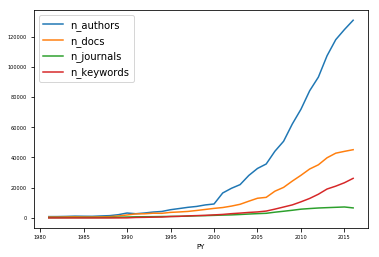

In [3]:
plt.close()
pdf = df.set_index('PY')
pdf.plot()

plt.show()

In [4]:
def get_year_words(row,docs):
    py = row['PY']
    docs = docs.filter(PY=py)
    abstracts, docsizes, ids, citations = proc_docs(docs, stoplist, False, False)
    try:
        count_vectorizer = CountVectorizer(
            min_df=5,
            max_features=100000,
            ngram_range=(1,1),
            stop_words=stoplist
        )
        tfidf = count_vectorizer.fit_transform(abstracts).shape[1]
    except:
        tfidf = 0
    return tfidf
    
abstracts = get_year_words({'PY':1990},docs)
df['n_words'] = df.apply(lambda x: get_year_words(x,docs),axis=1)

df.tail()

,PY,n_authors,n_docs,n_journals,n_keywords,n_words
31,2012,93197,35159,6564,15682,23621
32,2013,107370,39823,6799,19130,25134
33,2014,118021,42858,7022,21037,26353
34,2015,124707,44057,7244,23294,27228
35,2016,130851,45159,6626,26196,27568


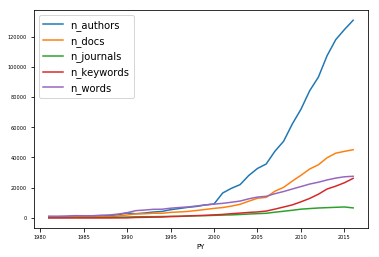

In [5]:
plt.close()
pdf = df.set_index('PY')
pdf.plot()
plt.savefig('../plots/vs_{}.png'.format(q.title))
plt.show()

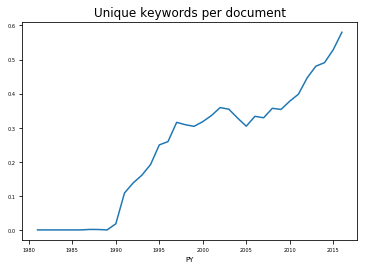

In [6]:
df['key_docs'] = df['n_keywords']/df['n_docs']

plt.close()
pdf = df.set_index('PY')['key_docs']
pdf.plot()
plt.title("Unique keywords per document")
plt.savefig('../plots/scaled_variety_{}.png'.format(q.title))

plt.show()

In [7]:
df.to_csv('../data/vs_{}.csv'.format(q.title),index=False)

  require(slam)
  df[,"z"] <- df[,field]
  df <- df %>%
    ungroup() %>%
    filter(PY >=y1 & PY <=y2 & PY%%5==0 & !is.na(z)) %>%
    group_by(z)
  
  totals <- df %>%
    mutate(
      v1 = n[which.min(PY)],
      v2 = n[which.max(PY)],
      Growth = round(((v2/v1)^(1/(y2-y1))-1)*100) ,
      period=paste0("Total: ",y1,"-",y2)
    ) %>%
    select(period,z,Growth) 
  
  df_sum <- df %>%
    mutate(
      change = n- lag(n),
      Growth = round(((n/lag(n))^(1/(PY-lag(PY)))-1)*100),
      period = paste0(lag(PY),"-",PY)
    ) %>%
    filter(!is.na(change)) %>%
    select(period,z,Growth)

In [9]:
docs = df[['PY','n_docs']]
docs['lower_bound'] = docs['n_docs']
docs['upper_bound'] = docs['n_docs']

def growth_rate(df,v,nyears=0):
    if nyears > 0:
        df = df[df['PY']>df.max()['PY']-nyears]
    y1 = df.min()['PY']
    y2 = df.max()['PY']
    v1 = df[df['PY']==y1][v].iloc[0]
    v2 = df[df['PY']==y2][v].iloc[0]
    g = round(((v2/v1)**(1/(y2-y1))-1)*100,2)
    return g

#docs.head()

grate = growth_rate(df,'n_docs',15)
print(grate)

docs.tail()

for y in [2017,2018,2019,2020,2021]:
    r = pd.DataFrame(data={
        'PY':y,
        'lower_bound': docs[docs['PY']==y-1]['lower_bound'],
        'upper_bound': docs[docs['PY']==y-1]['upper_bound'].iloc[0]*(1+grate/100)
    })
    docs = docs.append(r)
    
docs.tail()

docs.to_csv('../data/PY_docs_projections_{}.csv'.format(q.title),index=False)

13.34


/home/galm/software/django/tmvenv/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmvenv/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
docs

,PY,lower_bound,n_docs,upper_bound
0,1981,558,558.0,558.000000
1,1982,547,547.0,547.000000
2,1983,641,641.0,641.000000
3,1984,747,747.0,747.000000
4,1985,624,624.0,624.000000
5,1986,618,618.0,618.000000
6,1987,703,703.0,703.000000
7,1988,843,843.0,843.000000
8,1989,1299,1299.0,1299.000000
9,1990,1953,1953.0,1953.000000


In [ ]:
for y, group in docs.groupby('PY'):
    plt.bar(y,group['lower_bound'],color='#fbb4ae')
    if group['upper_bound'].iloc[0] > group['lower_bound'].iloc[0]:
        plt.bar(y,group['upper_bound'],color='#fbb4ae',alpha=0.5)

In [ ]:
def sum_field(row,df,col):
    yrange = list(range(row['start'],row['end']+1))
    df = df[df['PY'].isin(yrange)]
    return df.sum()[col]


## Docs by assessment period
aps = AR.objects.all().order_by('ar')
ardf = pd.DataFrame.from_dict(list(aps.values('ar','name','start','end')))
ardf['n_docs_lower'] = ardf.apply(lambda x: sum_field(x,docs,'lower_bound'),axis=1)
ardf['n_docs_upper'] = ardf.apply(lambda x: sum_field(x,docs,'upper_bound'),axis=1)
ardf.tail()

ardf.to_csv('../data/ar_docs_projections_{}.csv'.format(q.title),index=False)

In [ ]:
ardf = pd.DataFrame.from_dict(list(aps.values('ar','name','start','end')))

for c in df.columns:
    if c not in ["PY","key_docs"]:
        ardf[c] = ardf.apply(lambda x: sum_field(x,df,c),axis=1)
        
        
df['key_docs'] = ardf['n_keywords']/ardf['n_docs']        
ardf.head()

ardf.to_csv('../data/vs_by_ar_{}.csv'.format(q.title),index=False)